We First resampled PPG, ECG signals at 1Hz to align with SpO2 and other 1Hz data. Aligned files are stored in folder: "bidmc_signals_numerics"

In [1]:
import os
import glob
import pandas as pd
import numpy as np 

# Add lable to SpO2 value based on 90 and 85 sthreshold. Then concat all together.
base_path = '../../data/bidmc_signals_numerics'
all_files = glob.glob(os.path.join(base_path, '*.csv'))

df_list = []

for file in all_files:
    print(f"Reading file: {file}")
    df = pd.read_csv(file)

    file_name = os.path.basename(file)
    df.insert(0,'number',file_name[6:8])

    df.insert(6, 'spo2_90', np.where(df[' SpO2'] < 90, 1, 0)) 
    df.insert(7, 'spo2_85', np.where(df[' SpO2'] < 85, 1, 0)) 

    df_list.append(df)

result_df = pd.concat(df_list, ignore_index=True)
print(result_df)

output_path = '../../data/bidmc_signals_numerics/BIDMC_agg.csv'
result_df.to_csv(output_path, index=False)

print(f"File saved as {output_path}")

Reading file: ../../data/bidmc_signals_numerics\bidmc_01_merged.csv
Reading file: ../../data/bidmc_signals_numerics\bidmc_02_merged.csv
Reading file: ../../data/bidmc_signals_numerics\bidmc_03_merged.csv
Reading file: ../../data/bidmc_signals_numerics\bidmc_04_merged.csv
Reading file: ../../data/bidmc_signals_numerics\bidmc_05_merged.csv
Reading file: ../../data/bidmc_signals_numerics\bidmc_06_merged.csv
Reading file: ../../data/bidmc_signals_numerics\bidmc_07_merged.csv
Reading file: ../../data/bidmc_signals_numerics\bidmc_08_merged.csv
Reading file: ../../data/bidmc_signals_numerics\bidmc_09_merged.csv
Reading file: ../../data/bidmc_signals_numerics\bidmc_10_merged.csv
Reading file: ../../data/bidmc_signals_numerics\bidmc_11_merged.csv
Reading file: ../../data/bidmc_signals_numerics\bidmc_12_merged.csv
Reading file: ../../data/bidmc_signals_numerics\bidmc_13_merged.csv
Reading file: ../../data/bidmc_signals_numerics\bidmc_14_merged.csv
Reading file: ../../data/bidmc_signals_numerics\

In [2]:
# Count labels and calculate percentages
output_path = '../../data/bidmc_signals_numerics/BIDMC_agg.csv'
df = pd.read_csv(output_path)
results = {}
for threshold in ['spo2_90', 'spo2_85']:
    label_counts = df[threshold].value_counts()
    total = label_counts.sum()
    ones = label_counts.get(1, 0)
    percentage_ones = (ones / total) * 100
    
    results[threshold] = {
        'Total_0': label_counts.get(0, 0),
        'Total_1': ones,
        'Percentage_1': percentage_ones
    }

# Display results
for threshold, data in results.items():
    print(f"Threshold {threshold}:")
    print(f"  Total 0 labels: {data['Total_0']}")
    print(f"  Total 1 labels: {data['Total_1']}")
    print(f"  Percentage of 1 labels: {data['Percentage_1']:.2f}%\n")


Threshold spo2_90:
  Total 0 labels: 24528
  Total 1 labels: 964
  Percentage of 1 labels: 3.78%

Threshold spo2_85:
  Total 0 labels: 25246
  Total 1 labels: 246
  Percentage of 1 labels: 0.97%



The code below are modified from Fall2024, XGboot model.

Training XGBoost models and calculating metrics:   0%|          | 0/2 [00:00<?, ?it/s]


Training XGBoost model for target: spo2_90
Accuracy for spo2_90: 1.0000
AUC for spo2_90: 1.0000


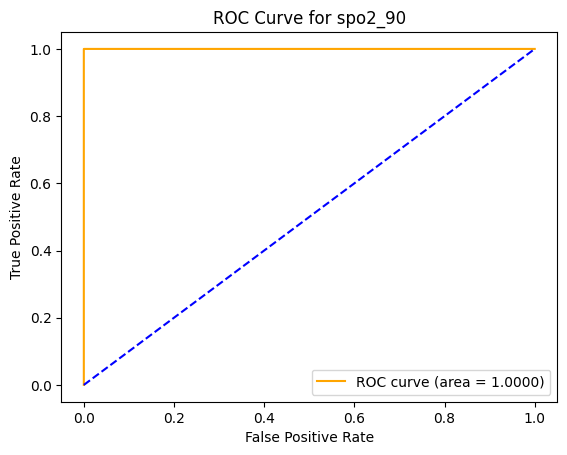

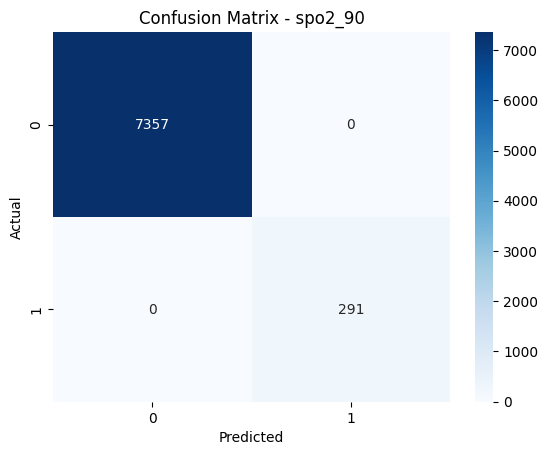

Top 10 features for spo2_90:
    Feature  Importance
8       MCL    0.254252
11   RESP_x    0.252221
10    PULSE    0.148824
4        HR    0.091714
6        II    0.076349
5         I    0.070416
13        V    0.066462
2       AVR    0.022934
9     PLETH    0.005344
12   RESP_y    0.004197


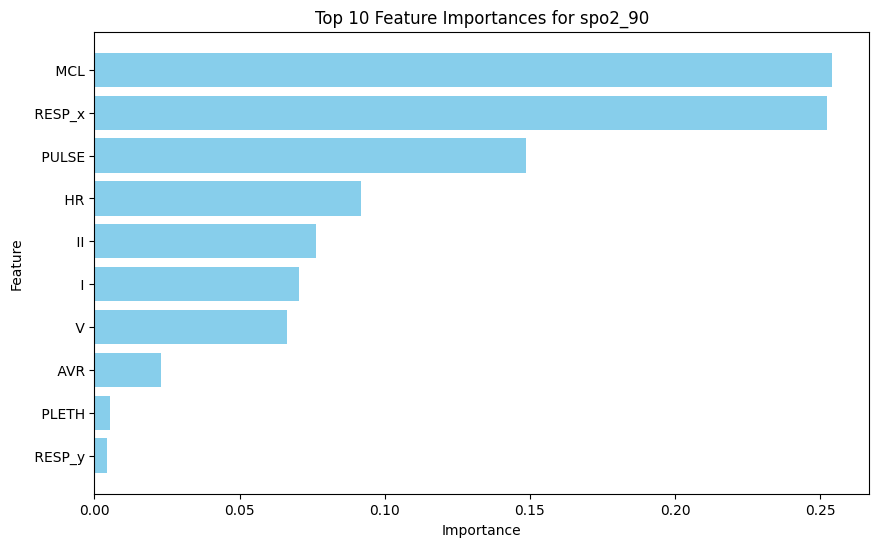

Training XGBoost models and calculating metrics:  50%|█████     | 1/2 [00:00<00:00,  2.91it/s]


Training XGBoost model for target: spo2_85
Accuracy for spo2_85: 0.9888
AUC for spo2_85: 0.9940


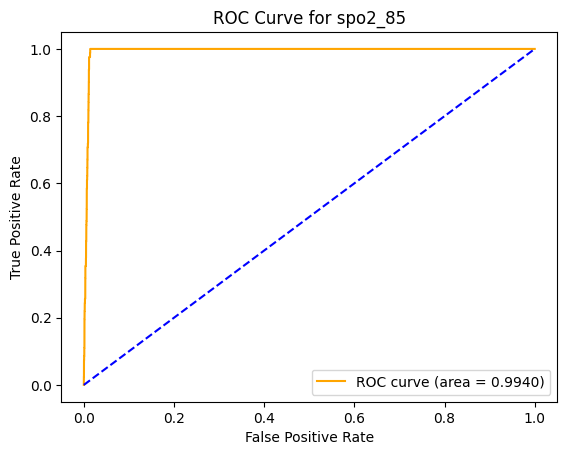

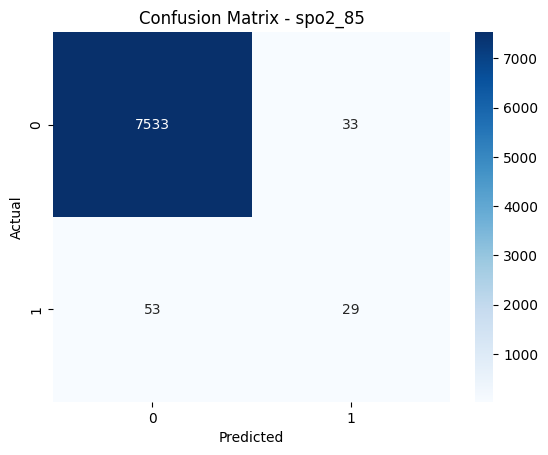

Top 10 features for spo2_85:
    Feature  Importance
11   RESP_x    0.320507
10    PULSE    0.128395
4        HR    0.111990
6        II    0.097621
5         I    0.077683
8       MCL    0.059955
0       ABP    0.044794
13        V    0.041575
2       AVR    0.034571
3       CVP    0.029663


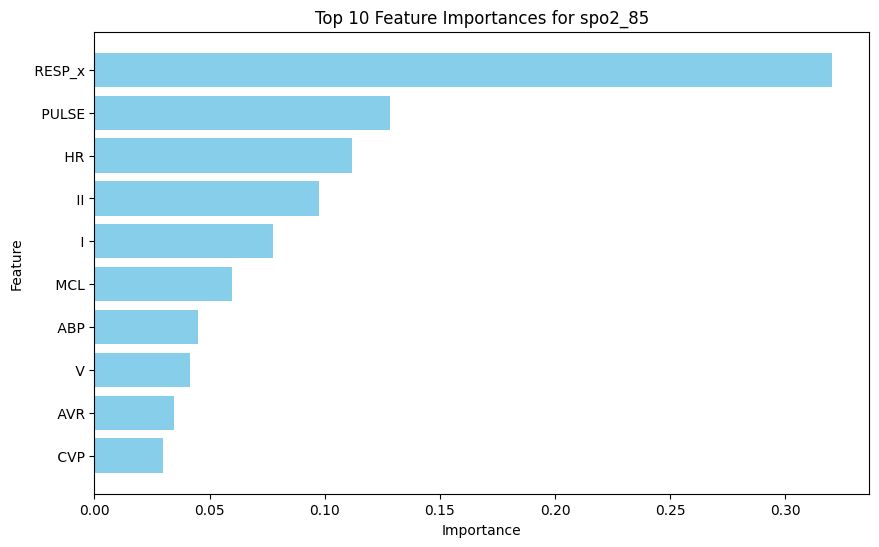

Training XGBoost models and calculating metrics: 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

output_path = '../../data/bidmc_signals_numerics/BIDMC_agg.csv'
df = pd.read_csv(output_path)

# Remove NaN or infinite values from the data
df.fillna(0, inplace=True)
df.replace([np.inf, -np.inf], 0, inplace=True)

# Set features (X) and target columns (spo2_90 and spo2_85)
X = df[df.columns.difference(['number', 'Time [s]',' SpO2', 'spo2_90', 'spo2_85'])].values  # Exclude ID and answer columns
targets = ['spo2_90', 'spo2_85']

# Normalize X to scale the features between 0 and 1
X = X / (np.max(X, axis=0) + 1e-8)
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

# Iterate through each target column for model training
for target in tqdm(targets, desc="Training XGBoost models and calculating metrics"):
    print(f"\nTraining XGBoost model for target: {target}")
    y = df[target].values

    # Handle imbalanced classes with SMOTE
    # smote = SMOTE(random_state=0)
    # X_resampled, y_resampled = smote.fit_resample(X, y)

    # Split data into training and test sets
    # X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # Train XGBoost model
    model = XGBClassifier(
        eval_metric='logloss',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=0
    )
    model.fit(X_train, y_train)

    # Predict probabilities and labels
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for class 1
    y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary labels

    # Calculate Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {target}: {accuracy:.4f}")

    # Calculate AUC
    auc_score = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC for {target}: {auc_score:.4f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.figure()
    plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {target}')
    plt.legend()
    plt.show()

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title(f"Confusion Matrix - {target}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    feature_importances = model.feature_importances_
    features = df.columns.difference(['number', 'Time [s]',' SpO2', 'spo2_90', 'spo2_85'])  # Feature names

    # Create a DataFrame for feature importances
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Get the top 10 features
    top_features = importance_df.head(10)
    print(f"Top 10 features for {target}:\n{top_features}")

    # Plot top 10 features as a bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Top 10 Feature Importances for {target}')
    plt.gca().invert_yaxis()
    plt.show()